In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import warnings
import random
warnings.filterwarnings('ignore')
import transformers
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Subset
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
from transformers import AdamW
from utils.dataloader import AITextDataset
from models.bert import BertAITextDetector
from models.gpt import GPTAITextDetector
from models.roberta_model import RobertaAITextDetector
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc,accuracy_score

In [3]:
# Enforce reproducibility
seed = 25
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Bert tokenizer

In [6]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

In [7]:
PATH = "/content/drive/MyDrive/dataset"
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
arch ='bert'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
max_length =128
epochs = 5

### Training and validation loops

In [10]:
def validation_loop(dataloader,model,loss_fn):
    model.eval()
    loop = tqdm(enumerate(dataloader),leave=False,total=len(dataloader))
    num_correct = 0
    target_count = 0
    total_loss  = 0
    with torch.no_grad():
        for batch, dl in loop:
            ids=dl['ids'].to(device)
            if arch =='bert':
                token_type_ids=dl['token_type_ids'].to(device)
            mask= dl['mask'].to(device)
            label=dl['target'].to(device)
            label = label.unsqueeze(1).to(device)
            if arch =='bert':
                output = model(ids,mask,token_type_ids)
            else:
                output = model(ids,mask)

            label = label.type_as(output) 
            loss = loss_fn(output,label)               
            output =output.cpu().detach().numpy()
            pred = np.where(output >= 0, 1, 0)
            target_count += label.size(0)
            

            # compute accuracy per batch
            num_correct+= sum(1 for a, b in zip(pred, label) if a[0] == b[0])
            total_loss+= loss.item() 
       
    print(f'Validation loss :{round(float(total_loss/len(dataloader)),3)}   with accuracy {round(float(100 * num_correct /target_count),3)}%')
    return float(100 * num_correct / target_count),round(float(total_loss/len(dataloader)),3)
    

def training_loop(epochs,dataloader,val_dataloader,model,loss_fn,optimizer,scheduler):
    model.train()
    train_loss = []
    val_loss =[]
    for  epoch in range(1,epochs+1):       
        loop=tqdm(enumerate(dataloader),leave=False,total=len(dataloader))
        total_loss  = 0
        num_correct = 0
        target_count = 0
        for batch, dl in loop:
            ids=dl['ids'].to(device)
            if arch =='bert':
                token_type_ids = dl['token_type_ids'].to(device)
            mask= dl['mask'].to(device)
            label=dl['target'].to(device)
            label = label.unsqueeze(1).to(device)

            optimizer.zero_grad()
            
            if arch =='bert':
                output = model(ids,mask,token_type_ids)
            else:
                output = model(ids,mask)
            label = label.type_as(output)

            loss = loss_fn(output,label)
            # back propagate
            loss.backward()  
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)          
            optimizer.step()
            scheduler.step()
            
            output = output.cpu().detach().numpy()
            pred = np.where(output >= 0, 1, 0)

            target_count += label.size(0)
            
            # compute accuracy per batch
            num_correct+= sum(1 for a, b in zip(pred, label) if a[0] == b[0]) 
              
          
            total_loss+= loss.item() 
        train_loss.append(round(float(total_loss/len(dataloader)),3))
        print(f'Training loss :{round(float(total_loss/len(dataloader)),3)}   with accuracy {round(float(100 * num_correct /target_count),3)}%')
        if epoch%1 == 0:
            val_acc, v_loss = validation_loop(val_dataloader,model,loss_fn)   
            val_loss.append(v_loss)
            # Show progress while training
            loop.set_description(f'Epochs={epoch}/{epochs}')
            # saved model 
            torch.save(model.state_dict(), PATH+'/ai-text-classifier-'+str(val_acc)+'.pth')

    return model, train_loss,val_loss

###  Fine-tuning Bert Model

In [ ]:
model_ = BertAITextDetector(dropout = 0.20)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model_.cuda()

BertAITextDetector(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

## Fine-tune model for few epochs

In [ ]:
from transformers import AdamW,get_linear_schedule_with_warmup
import torch.nn as nn
import time
PATH ='/content/drive/MyDrive/dataset/bertNew'

dataset = AITextDataset(tokenizer =tokenizer, max_length = 128, data_type ='train',model_type ='bert',file_path ='/content/drive/MyDrive/dataset/train_set.json')
dataset_size = len(dataset)
validation_split = 0.20
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_split = Subset(dataset, train_indices)

val_split = Subset(dataset, val_indices)
train_dataloader = torch.utils.data.DataLoader(train_split, batch_size=16, shuffle=True, num_workers=4,collate_fn = dataset.collate_fn_train)
val_dataloader = torch.utils.data.DataLoader(val_split, batch_size=16, shuffle=False, num_workers=4,collate_fn= dataset.collate_fn_train)
##Training parameters:
epochs = 5
# construct an optimizer
arch ='bert'
optimizer = AdamW(model_.parameters(), lr=2e-5,eps = 1e-08)

# Set up the learning rate scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
loss_fn = nn.BCEWithLogitsLoss()

training_start_time = time.time()

model,train_loss,val_loss = training_loop(epochs, train_dataloader,val_dataloader, model_, loss_fn, optimizer,scheduler)
print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

torch.save(model.state_dict(), PATH +'/ai-text-'+arch+str(epochs)+'-classifier-max-length-'+str(max_length)+'.pth')

Training loss :0.573   with accuracy 70.125%


Validation loss :0.484   with accuracy 77.5%


Training loss :0.327   with accuracy 87.469%


Validation loss :0.444   with accuracy 80.875%


Training loss :0.142   with accuracy 95.656%


Validation loss :0.58   with accuracy 82.875%


Training loss :0.054   with accuracy 98.75%


Validation loss :0.722   with accuracy 81.5%


Training loss :0.025   with accuracy 99.469%


Validation loss :0.75   with accuracy 82.875%
Training finished, took 402.41s


In [ ]:
dataset = AITextDataset(tokenizer =tokenizer, max_length = 128, data_type ='train',model_type ='bert',file_path ='/content/drive/MyDrive/dataset/train_set.json')
dataset_size = len(dataset)
validation_split = 0.20
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_split = Subset(dataset, train_indices)

val_split = Subset(dataset, val_indices)
train_dataloader = torch.utils.data.DataLoader(train_split, batch_size=16, shuffle=True, num_workers=4,collate_fn = dataset.collate_fn_train)
val_dataloader = torch.utils.data.DataLoader(val_split, batch_size=1, shuffle=False, num_workers=4,collate_fn= dataset.collate_fn_train)


model_.eval()
model_.to(device)
actuals = []
predictions = []

with torch.no_grad():
  loop=tqdm(enumerate(val_dataloader),leave=False,total=len(val_dataloader))
  for i,(batch, dl) in enumerate(loop):
    ids = dl['ids'].to(device)
    if arch =='bert':
      token_type_ids = dl['token_type_ids'].to(device)
    mask= dl['mask'].to(device)
    label = dl['target'].detach().numpy().tolist()[0]
    if arch =='bert':
      output = model_(ids,mask,token_type_ids)
    else:
      output = model_(ids,mask)
    output = output.cpu().detach().numpy()
    pred = np.where(output >= 0, 1, 0)  
    row = pred.tolist()[0][0]
    actuals.append(label)
    predictions.append(row) 

In [ ]:
true_labels = np.array(actuals)
pred_labels = np.array(predictions)
C = confusion_matrix(true_labels,pred_labels)
C = C / C.astype(np.float).sum(axis=1)


In [ ]:
print('Accuracy is {}'.format(accuracy_score(true_labels,pred_labels)))

Accuracy is 0.96875


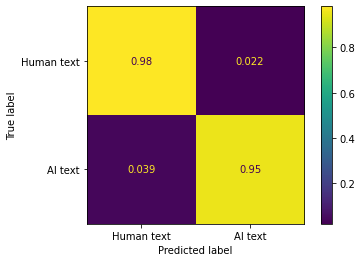

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=C ,display_labels=['Human text','AI text'])
disp.plot()

In [ ]:
import csv
dataset = AITextDataset(tokenizer = tokenizer, max_length = max_length, data_type = 'test', model_type = 'bert', file_path = '/content/drive/MyDrive/dataset/test_set.json')
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False, collate_fn = dataset.collate_fn_test)
model_.load_state_dict(torch.load(PATH+'/ai-text-classifier-82.875.pth'))
model_.eval()
model_.to(device)

with torch.no_grad():
    with open(PATH+"/submission-bertnew.csv", "w") as file:
        csv_out = csv.writer(file)
        csv_out.writerow(['id','label'])
        loop=tqdm(enumerate(dataloader),leave=False,total=len(dataloader))

        for i,(batch, dl) in enumerate(loop):
            ids = dl['ids'].to(device)
            if arch =='bert':
                token_type_ids=dl['token_type_ids'].to(device)
            mask= dl['mask'].to(device)
           
            if arch =='bert':
                output = model_(ids,mask,token_type_ids)
            else:
                 output=model_(ids,mask)
          
            output =output.cpu().detach().numpy()
            pred = np.where(output >= 0, 1, 0)  
            row = pred.tolist()[0][0]
            csv_out.writerow([i, row])
 




### Fine tune RoBERTa model

In [ ]:
model_robert = RobertaAITextDetector()
model_robert.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaAITextDetector(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

### Tokenizer for RoBERTa model

In [ ]:
tokenizer = transformers.RobertaTokenizer.from_pretrained("roberta-base")

### Fine-tune for few epochs

In [ ]:
from transformers import AdamW,get_linear_schedule_with_warmup
import torch.nn as nn
PATH ='/content/drive/MyDrive/dataset/roberta02'
dataset = AITextDataset(tokenizer =tokenizer, max_length = 128, data_type ='train',model_type ='robert',file_path ='/content/drive/MyDrive/dataset/train_set.json')
dataset_size = len(dataset)
validation_split = 0.20
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_split = Subset(dataset, train_indices)

val_split = Subset(dataset, val_indices)
train_dataloader = torch.utils.data.DataLoader(train_split, batch_size=16, shuffle=True, num_workers=4,collate_fn = dataset.collate_fn_train)
val_dataloader = torch.utils.data.DataLoader(val_split, batch_size=16, shuffle=False, num_workers=4,collate_fn= dataset.collate_fn_train)
##Training parameters:
epochs = 4
# construct an optimizer
arch ='robert'
# optimizer_grouped_parameters = get_optimizer_grouped_parameters(model_robert.bert)
optimizer = AdamW(model_robert.parameters(), lr= 3e-5,eps = 1e-06,betas =(0.9,0.98),weight_decay =0.10,correct_bias =True)
# optimizer = PriorWD(optimizer, use_prior_wd=True)

# Set up the learning rate scheduler
total_steps = len(train_dataloader) * epochs
steps_per_epoch =  len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = steps_per_epoch, # Default value
                                                num_training_steps=total_steps)
loss_fn = nn.BCEWithLogitsLoss()

model,train_loss,val_loss = training_loop(epochs, train_dataloader,val_dataloader, model_robert, loss_fn, optimizer,scheduler)

torch.save(model.state_dict(), PATH +'/ai-text-next'+arch+str(epochs)+'-classifier-max-length-'+str(max_length)+'.pth')

Training loss :0.641   with accuracy 65.031%


Validation loss :0.611   with accuracy 67.0%


Training loss :0.427   with accuracy 80.344%


Validation loss :0.424   with accuracy 84.625%


Training loss :0.267   with accuracy 89.781%


Validation loss :0.243   with accuracy 89.5%


Training loss :0.146   with accuracy 94.438%


Validation loss :0.226   with accuracy 91.375%


Training loss :0.085   with accuracy 97.344%


Validation loss :0.276   with accuracy 90.375%


Training loss :0.037   with accuracy 99.219%


Validation loss :0.486   with accuracy 88.875%


Training loss :0.032   with accuracy 99.438%


Validation loss :0.413   with accuracy 90.0%


In [ ]:
import csv
dataset = AITextDataset(tokenizer = tokenizer, max_length = max_length, data_type = 'test', model_type = 'robe', file_path = '/content/drive/MyDrive/dataset/test_set.json')
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False, collate_fn = dataset.collate_fn_test)
model_robert.load_state_dict(torch.load(PATH+'/ai-text-classifier-91.25.pth'))
model_robert.eval()
model_robert.to(device)

with torch.no_grad():
    with open(PATH+"/submission-robertnew-v2.csv", "w") as file:
        csv_out = csv.writer(file)
        csv_out.writerow(['id','label'])
        loop = tqdm(enumerate(dataloader),leave=False,total=len(dataloader))

        for i,(batch, dl) in enumerate(loop):
            ids = dl['ids'].to(device)
            if arch =='bert':
                token_type_ids=dl['token_type_ids'].to(device)
            mask= dl['mask'].to(device)
           
            if arch =='bert':
                output = model_robert(ids,mask,token_type_ids)
            else:
                 output = model_robert(ids,mask)
          
            output = output.cpu().detach().numpy()
            pred = np.where(output >= 0, 1, 0)  
            row = pred.tolist()[0][0]
            csv_out.writerow([i, row])

###  Visualize training and validation loss 

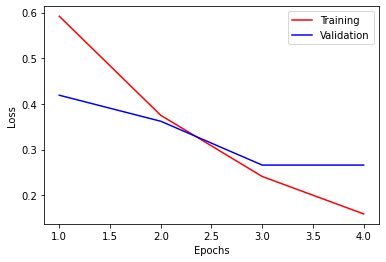

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,epochs+1),train_loss,'-r',label='Training')
plt.plot(range(1,epochs+1),val_loss,'b',label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
true_labels = np.array(actuals)
pred_labels = np.array(predictions)
C = confusion_matrix(true_labels,pred_labels)
C = C / C.astype(np.float).sum(axis=1)

In [ ]:
print('Accuracy is {}'.format(accuracy_score(true_labels,pred_labels)))

Accuracy is 0.91625


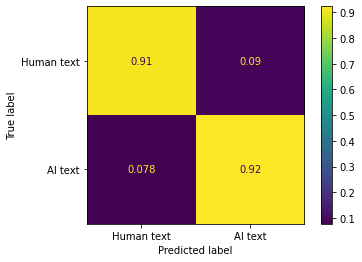

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=C ,display_labels=['Human text','AI text'])
disp.plot()

**Robert model inference on test set**

In [ ]:
import csv
dataset = AITextDataset(tokenizer = tokenizer, max_length = max_length, data_type = 'test', model_type = 'robe', file_path = '/content/drive/MyDrive/dataset/test_set.json')
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False, collate_fn = dataset.collate_fn_test)
model_robert.load_state_dict(torch.load(PATH+'/ai-text-classifier-90.625.pth'))
model_robert.eval()
model_robert.to(device)

with torch.no_grad():
    with open(PATH+"/submission-robert22.csv", "w") as file:
        csv_out = csv.writer(file)
        csv_out.writerow(['id','label'])
        loop = tqdm(enumerate(dataloader),leave=False,total=len(dataloader))

        for i,(batch, dl) in enumerate(loop):
            ids = dl['ids'].to(device)
            if arch =='bert':
                token_type_ids=dl['token_type_ids'].to(device)
            mask = dl['mask'].to(device)
           
            if arch =='bert':
                output = model_robert(ids,mask,token_type_ids)
            else:
                 output = model_robert(ids,mask)
          
            output = output.cpu().detach().numpy()
            pred = np.where(output >= 0, 1, 0)  
            row = pred.tolist()[0][0]
            csv_out.writerow([i, row])
 




###  Fine-tune GPT model for Text Classification

In [ ]:
model_gpt = GPTAITextDetector(dropout = 0.10)
model_gpt.cuda()
PATH = '/content/drive/MyDrive/dataset/gpt'

In [ ]:
# Get model's tokenizer.
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({"cls_token": "[CLS]"})
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model_gpt.base.resize_token_embeddings(len(tokenizer))

Embedding(50259, 768)

In [ ]:
from transformers import AdamW,get_linear_schedule_with_warmup
import torch.nn as nn

dataset = AITextDataset(tokenizer =tokenizer, max_length = 128, data_type ='train',model_type ='gpt',file_path ='/content/drive/MyDrive/dataset/train_set.json')
dataset_size = len(dataset)
validation_split = 0.20
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_split = Subset(dataset, train_indices)

val_split = Subset(dataset, val_indices)
train_dataloader = torch.utils.data.DataLoader(train_split, batch_size=32, shuffle=True, num_workers=4,collate_fn = dataset.collate_fn_train)
val_dataloader = torch.utils.data.DataLoader(val_split, batch_size=32, shuffle=False, num_workers=4,collate_fn= dataset.collate_fn_train)
##Training parameters:
epochs = 4
# construct an optimizer
arch ='gpt'
optimizer = AdamW(model_gpt.parameters(), lr=3e-5,eps = 1e-8)

# Set up the learning rate scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
loss_fn = nn.BCEWithLogitsLoss()

model,train_loss,val_loss = training_loop(epochs, train_dataloader,val_dataloader, model_gpt, loss_fn, optimizer,scheduler)

torch.save(model.state_dict(), PATH +'/ai-text-'+arch+str(epochs)+'-classifier-max-length-'+str(max_length)+'.pth')

Training loss :0.674   with accuracy 56.688%


Validation loss :0.618   with accuracy 65.875%


Training loss :0.529   with accuracy 74.906%


Validation loss :0.512   with accuracy 74.75%


Training loss :0.349   with accuracy 87.219%


Validation loss :0.402   with accuracy 84.0%


Training loss :0.197   with accuracy 93.969%


Validation loss :0.326   with accuracy 87.375%


Training loss :0.099   with accuracy 97.906%


Validation loss :0.363   with accuracy 86.625%


Training loss :0.051   with accuracy 99.312%


Validation loss :0.391   with accuracy 86.375%


In [ ]:
import csv
dataset = AITextDataset(tokenizer = tokenizer, max_length = max_length, data_type = 'test', model_type = 'robe', file_path = '/content/drive/MyDrive/dataset/test_set.json')
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False, collate_fn = dataset.collate_fn_test)
model_gpt.load_state_dict(torch.load(PATH+'/ai-text-classifier-87.375.pth'))
model_gpt.eval()
model_gpt.to(device)

with torch.no_grad():
    with open(PATH+"/submission-gpt2.csv", "w") as file:
        csv_out = csv.writer(file)
        csv_out.writerow(['id','label'])
        loop=tqdm(enumerate(dataloader),leave=False,total=len(dataloader))

        for i,(batch, dl) in enumerate(loop):
            ids = dl['ids'].to(device)
            if arch =='bert':
                token_type_ids=dl['token_type_ids'].to(device)
            mask= dl['mask'].to(device)
           
            if arch =='bert':
                output = model_gpt(ids,mask,token_type_ids)
            else:
                 output= model_gpt(ids,mask)
          
            output =output.cpu().detach().numpy()
            pred = np.where(output >= 0, 1, 0)  
            row = pred.tolist()[0][0]
            csv_out.writerow([i, row])
 




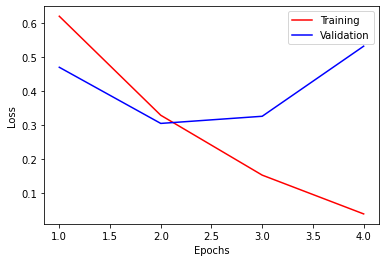

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,epochs+1),train_loss,'-r',label='Training')
plt.plot(range(1,epochs+1),val_loss,'b',label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()


In [ ]:
val_dataloader = torch.utils.data.DataLoader(val_split, batch_size=1, shuffle=False, num_workers=4,collate_fn= dataset.collate_fn_train)
model.eval()
model.to(device)
actuals = []
predictions = []
with torch.no_grad():
    loop = tqdm(enumerate(val_dataloader),leave=False,total=len(val_dataloader))
    for i,(batch, dl) in enumerate(loop):
        ids = dl['ids'].to(device)
        if arch =='bert':
            token_type_ids=dl['token_type_ids'].to(device)
        mask= dl['mask'].to(device)
        label = dl['target'].detach().numpy().tolist()[0]
        if arch =='bert':
            output = model(ids,mask,token_type_ids)
        else:
            output = model(ids,mask)
        output = output.cpu().detach().numpy()
        pred = np.where(output >= 0, 1, 0)  
        row = pred.tolist()[0][0]
        actuals.append(label)
        predictions.append(row)  
 

In [ ]:
true_labels = np.array(actuals)
pred_labels = np.array(predictions)
C = confusion_matrix(true_labels,pred_labels)
C = C / C.astype(np.float).sum(axis=1)

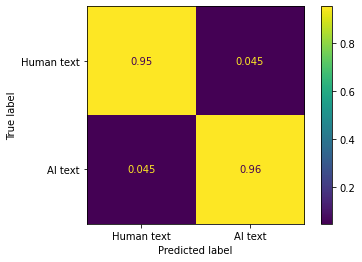

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=C ,display_labels=['Human text','AI text'])
disp.plot()